# 1. Bussiness Problem

## 1.1 Problem Description

The misdiagnosis of the many diseases impacts agricultural crops and can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, so computer-vision based model can help to efficiently classify these diseases.

## 1.2 Problem Statement

The dataset is taken from "Plant Pathology 2020 - FGVC7" Kaggle competition. In this competition, the challenge is to distinguish between leaves which are healthy, leaves which are infected with apple rust, leaves that have apple scab, and leaves with more than one disease.

Dataset : https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7

## 1.3 Business Objective

1. Build a model which gives maximum accuracy.
2. The model should have Strict Latency Constraint.

# 2. Importing all the necessary files and libraries

In [4]:
# importing important libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import keras
import cv2 as cv
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tf.keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from tf.keras.applications.resnet import ResNet50
from tf.keras.applications.efficientnet import EfficientNetB4
from tf.keras.models import Model
from tf.keras.layers import GlobalAveragePooling2D
from tf.keras.layers import Dense, Input, MaxPool2D, Flatten, Dropout
from tf.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

In [5]:
# loading train and test dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape :", train.shape)
print("Test shape :", test.shape)

Train shape : (1821, 5)
Test shape : (1821, 1)


In [6]:
# checking train dataframe
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
# checking test dataframe
test.head(2)

,image_id
0,Test_0
1,Test_1


In [8]:
# adding image path in train dataframe
train_id = train['image_id'].values
train_image_path = []
for i in train_id:
    train_image_path.append("images/" + i + ".jpg")
train['image_path'] = train_image_path
train.head()

,image_id,healthy,multiple_diseases,rust,scab,image_path
0,Train_0,0,0,0,1,images/Train_0.jpg
1,Train_1,0,1,0,0,images/Train_1.jpg
2,Train_2,1,0,0,0,images/Train_2.jpg
3,Train_3,0,0,1,0,images/Train_3.jpg
4,Train_4,1,0,0,0,images/Train_4.jpg


In [9]:
# adding image path in test dataframe
test_id = test['image_id'].values
test_image_path = []
for i in test_id:
    test_image_path.append("images/" + i + ".jpg")
test['image_path'] = test_image_path
test.head()

,image_id,image_path
0,Test_0,images/Test_0.jpg
1,Test_1,images/Test_1.jpg
2,Test_2,images/Test_2.jpg
3,Test_3,images/Test_3.jpg
4,Test_4,images/Test_4.jpg


Text(0, 0.5, 'No. of Images')

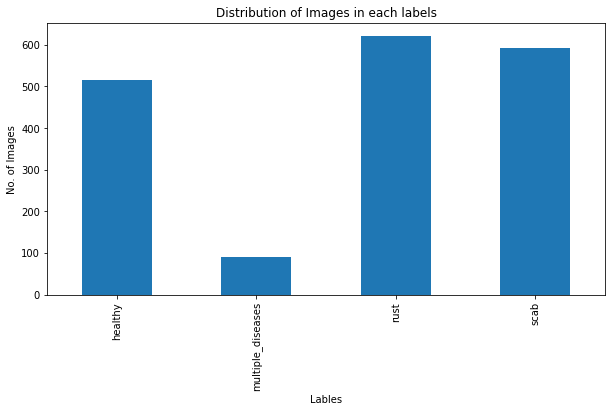

In [10]:
# plotting Distribution of Images in each labels in training dataframe
train[['healthy','multiple_diseases','rust','scab',]].sum().plot.bar(figsize = (10,5), title = "Distribution of Images in each labels")
plt.xlabel("Lables")
plt.ylabel("No. of Images")

In [11]:
# checking exact number of images in each labels
train[['healthy','multiple_diseases','rust','scab',]].sum()

healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64

## 2.2 Data Splitting

In [12]:
# splitting train dataset into train and validation dataset
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train.drop(['image_id'], axis = 1), test_size=0.20, random_state=15, stratify = train[['healthy','multiple_diseases','rust','scab']])
print(X_train.shape)
print(X_valid.shape)

(1456, 5)
(365, 5)


In [13]:
# checking train dataframe
X_train.head()

,healthy,multiple_diseases,rust,scab,image_path
1808,1,0,0,0,images/Train_1808.jpg
622,1,0,0,0,images/Train_622.jpg
883,0,0,0,1,images/Train_883.jpg
144,1,0,0,0,images/Train_144.jpg
469,0,0,1,0,images/Train_469.jpg


In [14]:
# checking validation dataframe
X_valid.head()

,healthy,multiple_diseases,rust,scab,image_path
1456,0,0,0,1,images/Train_1456.jpg
691,1,0,0,0,images/Train_691.jpg
1166,0,0,0,1,images/Train_1166.jpg
1806,0,0,0,1,images/Train_1806.jpg
55,1,0,0,0,images/Train_55.jpg


# 3. Exploratory Data Analysis (EDA)

## 3.1 Distribution of Lables

Text(0, 0.5, 'No. of Images')

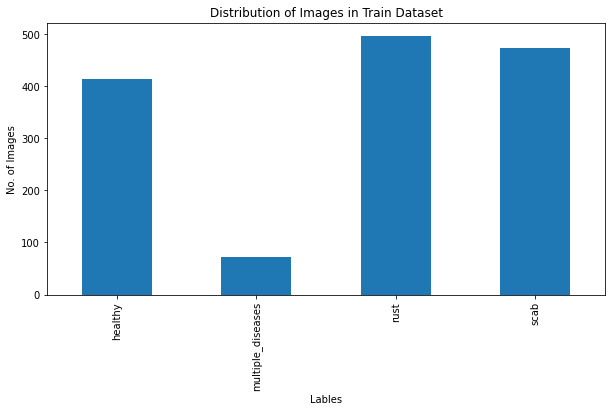

In [15]:
# plotting Distribution of Images in each labels in training dataframe
X_train[['healthy','multiple_diseases','rust','scab']].sum().plot.bar(figsize = (10,5), title = "Distribution of Images in Train Dataset")
plt.xlabel("Lables")
plt.ylabel("No. of Images")

It can be observe that 'multiple_diseases' label is highly under sampled as compared to other labels.

In [17]:
# checking exact number of images in each labels in training dataset
X_train[['healthy','multiple_diseases','rust','scab']].sum()

healthy              413
multiple_diseases     73
rust                 497
scab                 473
dtype: int64

In [18]:
# checking exact number of images in each labels validation dataset
X_valid[['healthy','multiple_diseases','rust','scab']].sum()

healthy              103
multiple_diseases     18
rust                 125
scab                 119
dtype: int64

## 3.2 Visualizing Healthy Leaves

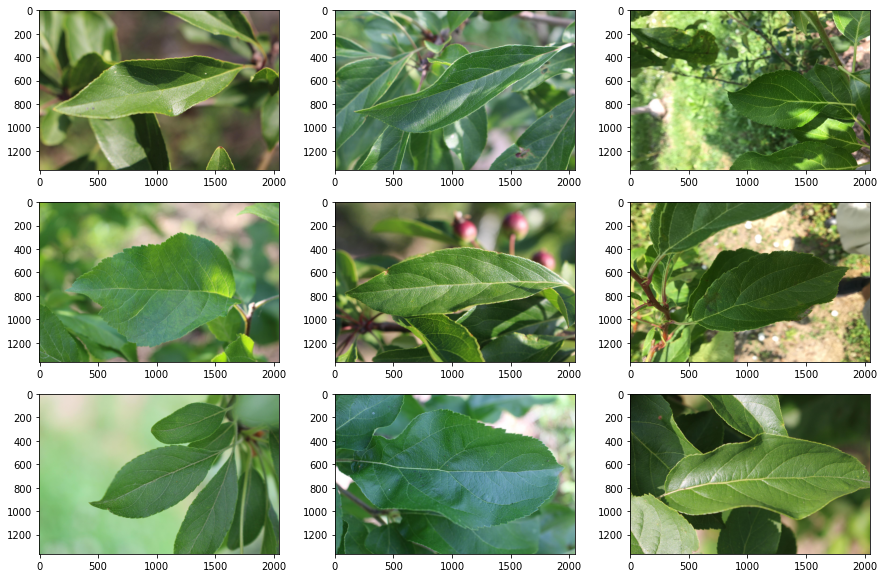

In [53]:
healthy = X_train[X_train['healthy']==1]['image_path'].values
cols = 3
rows = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for col in range(cols):
    for row in range(rows):
        ax[row, col].imshow(cv.cvtColor(cv.imread(healthy[row*3+col]), cv.COLOR_BGR2RGB))
plt.show()

We can observe that Healthy Leaves are all green and don't have any patches or spots.

## 3.3 Visualizing Rust Leaves

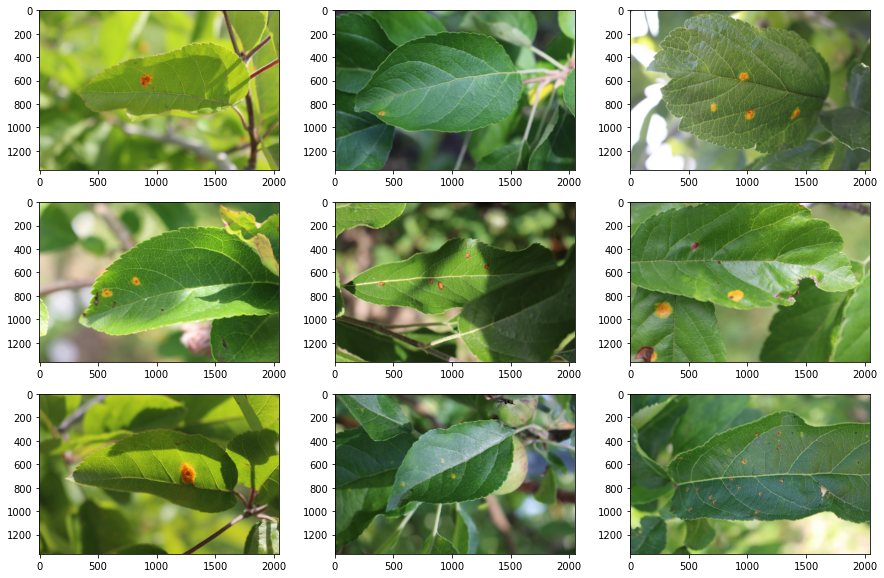

In [52]:
rust = X_train[X_train['rust']==1]['image_path'].values
cols = 3
rows = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for col in range(cols):
    for row in range(rows):
        ax[row, col].imshow(cv.cvtColor(cv.imread(rust[row*3+col]), cv.COLOR_BGR2RGB))
plt.show()

In Rust Leaves we can see the yellowish or brownish spots on leaves.

## 3.4 Visualizing Scab Leaves

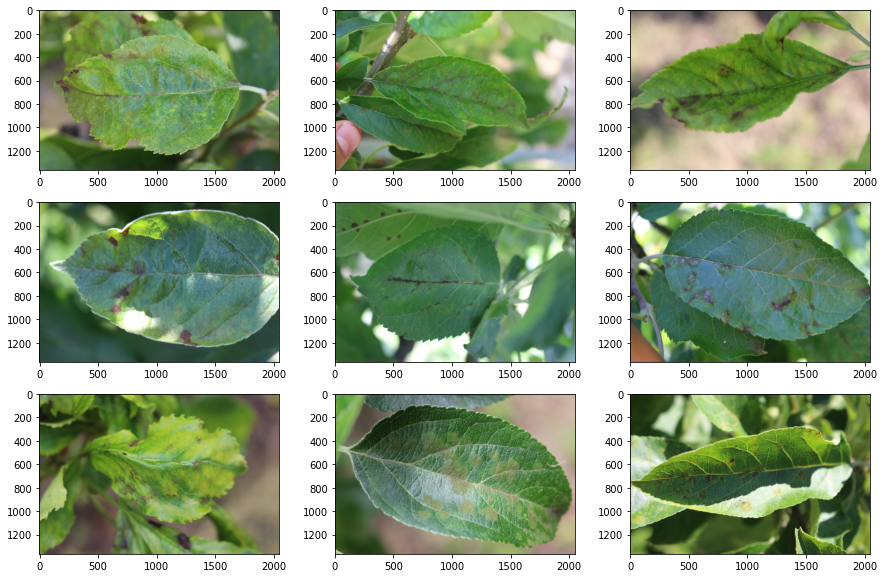

In [51]:
scab = X_train[X_train['scab']==1]['image_path'].values
cols = 3
rows = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for col in range(cols):
    for row in range(rows):
        ax[row, col].imshow(cv.cvtColor(cv.imread(scab[row*3+col]), cv.COLOR_BGR2RGB))
plt.show()

In Scab Leaves we can see the large brownish patches and some curling on leaves.

## 3.4 Visualizing Leaves with Multiple Diseases

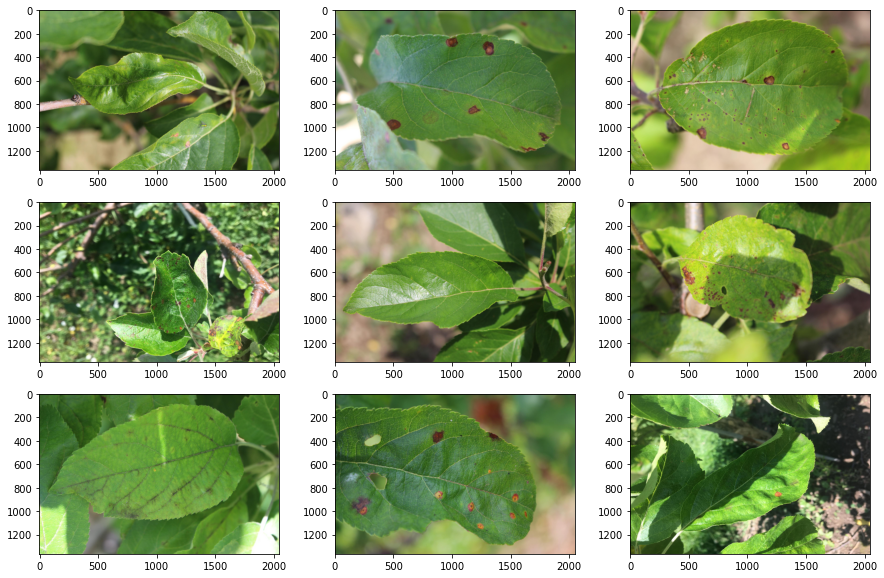

In [55]:
multiple_diseases = X_train[X_train['multiple_diseases']==1]['image_path'].values
cols = 3
rows = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows*10/3))
for col in range(cols):
    for row in range(rows):
        ax[row, col].imshow(cv.cvtColor(cv.imread(multiple_diseases[row*3+col]), cv.COLOR_BGR2RGB))
plt.show()

In Multiple Disease Leaves we can observe that there are both yellowish and  brownish patches, holes in leaves and lots of others multiple diseases on leaves. 

# 4. Preprocessing Image Data

## 4.1 Upsampling Train Dataset

As we can see that 'multiple_diseases' label is very imbalanced as compared to other three labels. So to get more accurate results we will be upsampling the training dataset. We will be using SMOTE library to upsample our training dataset.

In [19]:
# converting each training image into three dimensional array
X_train_arr = []
for img in tqdm(X_train['image_path'].values):
    loaded_img = load_img(img, target_size = (256, 256))
    img_arr = img_to_array(loaded_img)
    X_train_arr.append(img_arr)

X_train_arr = np.array(X_train_arr)
X_train_arr.shape

100%|██████████| 1456/1456 [14:59<00:00,  1.62it/s]


(1456, 256, 256, 3)

In [20]:
# creating y_train dataset
y_train_arr = X_train[['healthy','multiple_diseases','rust','scab']].values
y_train_arr.shape

(1456, 4)

In [21]:
# using SMOTE library to balance the training dataset
sm = SMOTE(random_state=15)
X_train_arr_new, y_train_new = sm.fit_resample(X_train_arr.reshape((-1, 256 * 256 * 3)), y_train_arr)
X_train_new = X_train_arr_new.reshape(-1, 256, 256, 3)
X_train_new.shape

(1988, 256, 256, 3)

In [22]:
y_train_new.shape

(1988, 4)

Text(0, 0.5, 'No. of Images')

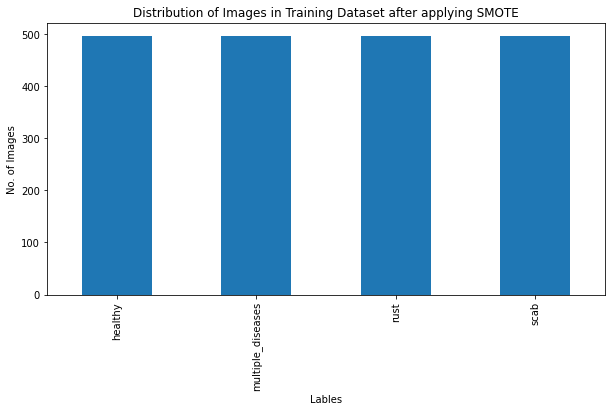

In [23]:
# Checking the Distribution of Images in each labels in training dataframe after balancing 
new_y_train_df = pd.DataFrame(data = y_train_new, columns = ['healthy','multiple_diseases','rust','scab'])
new_y_train_df.sum().plot.bar(figsize = (10,5), title = "Distribution of Images in Training Dataset after applying SMOTE")
plt.xlabel("Lables")
plt.ylabel("No. of Images")

## 4.2 Data Augmentation

In [24]:
# creating image augmentation
train_datagen = ImageDataGenerator(rotation_range = 20, brightness_range = (0.5, 1.5), shear_range = 0.2, 
                                   zoom_range =  0.2, horizontal_flip = True, vertical_flip = True, rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [30]:
# creating train, validation and test image generator
train_generator = train_datagen.flow(X_train_new, y_train_new, batch_size = 32, seed = 15, shuffle = True)

valid_generator = test_datagen.flow_from_dataframe(dataframe = X_valid, x_col = "image_path", y_col = ['healthy', 'multiple_diseases', 'rust', 'scab'], 
                                                   batch_size = 32, seed = 15, shuffle = False, class_mode = "raw", target_size = (256, 256))

test_generator = test_datagen.flow_from_dataframe(dataframe = test, x_col = "image_path", y_col = None, batch_size = 1, 
                                                  seed = 15, shuffle = False, class_mode = None,target_size = (256, 256))

Found 365 validated image filenames.
Found 1821 validated image filenames.


# 5. Deep Learning Models

## 5.1 VGG-19

Using Transfer Learning technique and training VGG-19 model with pre-trained weights of Imagenet model.

In [ ]:
# Input layer
input_layer = Input(shape=(256, 256, 3))

vgg19_model = VGG19(include_top = False, weights = 'imagenet', input_tensor = input_layer)

# mark loaded layers as not trainable
for layer in vgg19_model.layers:
	layer.trainable = False

# 2D Convolution layers
convo_layer = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',padding = "same", kernel_initializer = tf.keras.initializers.HeNormal(seed = 10))(vgg19_model.output)

# 2D Maxpooling layers
maxpool_layer = MaxPool2D(pool_size = (2,2), strides = (1,1), padding = 'valid')(convo_layer)

# Flatten Layer
flatten_layer = Flatten()(maxpool_layer)

#Dense layer
dense_layer_1 = Dense(512, activation = 'relu')(flatten_layer)

#Dense layer
dense_layer_2 = Dense(256, activation = 'relu')(dense_layer_1)

#Dense layer
dense_layer_3 = Dense(128, activation = 'relu')(dense_layer_2)

# Dense output layer
output = Dense(4, activation = 'softmax')(dense_layer_3)

#Creating a model
model_vgg19 = Model(inputs = input_layer, outputs = output)

In [ ]:
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# training vgg19 model
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 3, verbose = 1)

checkpoints = ModelCheckpoint(filepath = "best_model_vgg19.hdf5", monitor = 'val_accuracy', save_best_only = True, mode = 'max', verbose = 1)

callback_list = [lr_reduced, earlystop, checkpoints]

model_vgg19.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# calculating train and test step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

history_vgg19 = model_vgg19.fit(train_generator, steps_per_epoch = step_size_train, epochs = 50, 
                        callbacks = callback_list, validation_data = valid_generator, validation_steps = step_size_valid)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.3802 - accuracy: 0.3098
Epoch 1: val_accuracy improved from -inf to 0.42045, saving model to best_model_1.hdf5
62/62 [==============================] - 165s 2s/step - loss: 1.3802 - accuracy: 0.3098 - val_loss: 1.3043 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.2637 - accuracy: 0.4085
Epoch 2: val_accuracy did not improve from 0.42045
62/62 [==============================] - 57s 914ms/step - loss: 1.2637 - accuracy: 0.4085 - val_loss: 1.2100 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.1709 - accuracy: 0.4852
Epoch 3: val_accuracy improved from 0.42045 to 0.47727, saving model to best_model_1.hdf5
62/62 [==============================] - 58s 933ms/step - loss: 1.1709 - accuracy: 0.4852 - val_loss: 1.1613 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - ETA: 

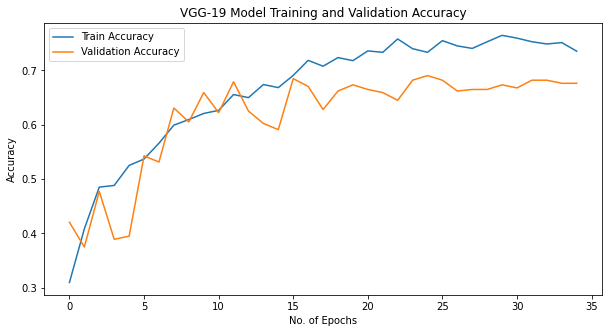

In [58]:
# plotting VGG-19 Model Accuracy history
fig, ax = plt.subplots(figsize = (10,5))
hist_vgg19 = history_vgg19.history
plt.plot(range(len(hist_vgg19["accuracy"])), hist_vgg19["accuracy"], label = "Train Accuracy")
plt.plot(range(len(hist_vgg19["val_accuracy"])), hist_vgg19["val_accuracy"], label = "Validation Accuracy")
plt.title('VGG-19 Model Training and Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

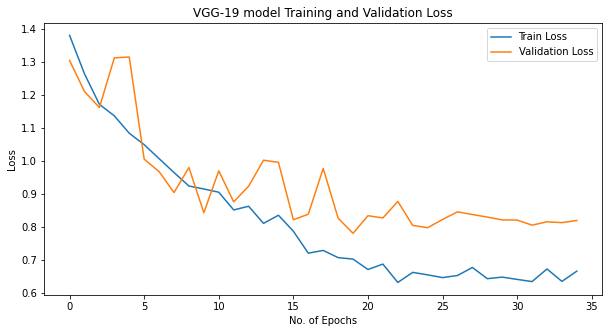

In [59]:
# plotting VGG-19 Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_vgg19 = history_vgg19.history
plt.plot(range(len(hist_vgg19["loss"])), hist_vgg19["loss"], label = "Train Loss")
plt.plot(range(len(hist_vgg19["val_loss"])), hist_vgg19["val_loss"], label = "Validation Loss")
plt.title('VGG-19 model Training and Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.2 ResNet50

Using Transfer Learning technique and training ResNet50 model with pre-trained weights of Imagenet model.

In [ ]:
# Input layer
input_layer = Input(shape=(256, 256, 3))

resnet50_model = ResNet50(include_top = False, weights = 'imagenet', input_tensor = input_layer)

# Global Pooling Layer
global_pooling_layer = GlobalAveragePooling2D()(resnet50_model.output)

# Dense layer
dense_layer_1 = Dense(256, activation = 'relu')(global_pooling_layer)

# Dense layer
dense_layer_2 = Dense(128, activation = 'relu')(dense_layer_1)

# Dense output layer
output = Dense(4, activation = 'softmax')(dense_layer_2)

#Creating a model
model_resnet50 = Model(inputs = input_layer, outputs = output)

In [ ]:
model_resnet50.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# training resnet50 model
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 15, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 3)

checkpoints = ModelCheckpoint(filepath = "best_model_resnet50.hdf5", monitor = 'val_accuracy', save_best_only = True, mode = 'max')

callback_list = [lr_reduced, earlystop, checkpoints]

model_resnet50.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# calculating train and test step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

history_resnet50 = model_resnet50.fit(train_generator, steps_per_epoch = step_size_train, epochs = 50, 
            callbacks = callback_list, validation_data = valid_generator, validation_steps = step_size_valid)

Epoch 1/50
62/62 [==============================] - 81s 1s/step - loss: 0.9107 - accuracy: 0.6672 - val_loss: 48.4700 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 67s 1s/step - loss: 0.5854 - accuracy: 0.7802 - val_loss: 13.1500 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 67s 1s/step - loss: 0.5393 - accuracy: 0.7965 - val_loss: 1.5691 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 66s 1s/step - loss: 0.4605 - accuracy: 0.8400 - val_loss: 1.4883 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 70s 1s/step - loss: 0.3159 - accuracy: 0.8829 - val_loss: 1.8039 - val_accuracy: 0.3409 - lr: 4.0000e-04
Epoch 6/50
62/62 [==============================] - 67s 1s/step - loss: 0.2684 - accuracy: 0.9100 - val_loss: 2.1998 - val_accuracy: 0.2784 - lr: 4.0000e-04
Epoch 7/50
62/62 [==============================] - 66s 1s/step - loss: 

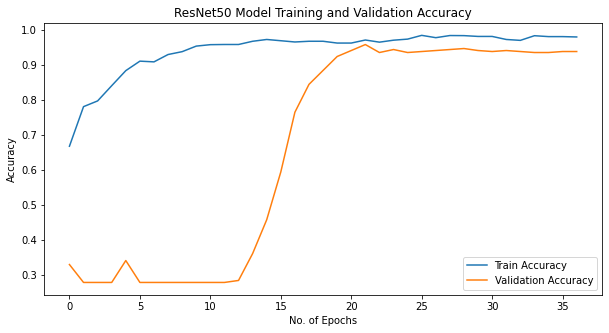

In [61]:
# plotting ResNet50 Model Accuracy history
fig, ax = plt.subplots(figsize = (10,5))
hist_resnet50 = history_resnet50.history
plt.plot(range(len(hist_resnet50["accuracy"])), hist_resnet50["accuracy"], label = "Train Accuracy")
plt.plot(range(len(hist_resnet50["val_accuracy"])), hist_resnet50["val_accuracy"], label = "Validation Accuracy")
plt.title('ResNet50 Model Training and Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

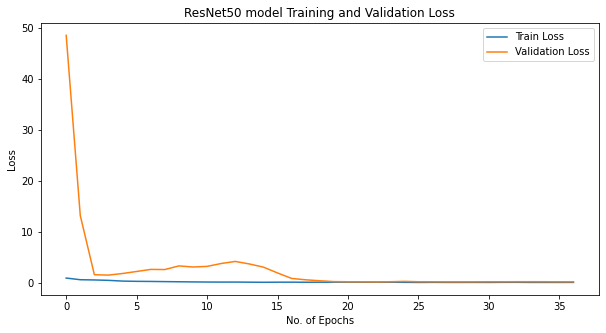

In [62]:
# plotting ResNet50 Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_resnet50 = history_resnet50.history
plt.plot(range(len(hist_resnet50["loss"])), hist_resnet50["loss"], label = "Train Loss")
plt.plot(range(len(hist_resnet50["val_loss"])), hist_resnet50["val_loss"], label = "Validation Loss")
plt.title('ResNet50 model Training and Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.3 EfficientNet B4

Using Transfer Learning technique and training EfficientNet B4 model with pre-trained weights of Imagenet model.

In [ ]:
# Input layer
input_layer = Input(shape=(256, 256, 3))

efficientnet_model = EfficientNetB4(include_top = False, weights = 'imagenet', input_tensor = input_layer)

# Global Pooling Layer
global_pooling_layer = GlobalAveragePooling2D()(efficientnet_model.output)

# Dense layer
dense_layer_1 = Dense(512, activation = 'relu')(global_pooling_layer)

# Dense layer
dense_layer_2 = Dense(256, activation = 'relu')(dense_layer_1)

# Dense layer
dense_layer_3 = Dense(128, activation = 'relu')(dense_layer_2)

# Dense output layer
output = Dense(4, activation = 'softmax')(dense_layer_3)

#Creating a model
model_efficientnetb4 = Model(inputs = input_layer, outputs = output)

71696384/71686520 [==============================] - 2s 0us/step


In [ ]:
# model summary
model_efficientnetb4.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f4e14548350>>

In [ ]:
# training efficientnetb4 model
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1)
lr_reduced = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 3)

checkpoints = ModelCheckpoint(filepath = "best_model_efficientnetb4.hdf5", monitor = 'val_accuracy', save_best_only = True, mode = 'max')

callback_list = [lr_reduced, earlystop, checkpoints]

model_efficientnetb4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# calculating train and test step size
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

history_efficientnetb4 = model_efficientnetb4.fit(train_generator, steps_per_epoch = step_size_train, epochs = 50, 
                                                  callbacks = callback_list, validation_data = valid_generator, validation_steps = step_size_valid)

Epoch 1/50
62/62 [==============================] - 156s 1s/step - loss: 0.7147 - accuracy: 0.7428 - val_loss: 1.8663 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 72s 1s/step - loss: 0.3925 - accuracy: 0.8727 - val_loss: 7.9537 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 72s 1s/step - loss: 0.3601 - accuracy: 0.8896 - val_loss: 3.7634 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 72s 1s/step - loss: 0.2742 - accuracy: 0.9162 - val_loss: 5.5150 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 73s 1s/step - loss: 0.1663 - accuracy: 0.9433 - val_loss: 5.2138 - val_accuracy: 0.2784 - lr: 4.0000e-04
Epoch 6/50
62/62 [==============================] - 73s 1s/step - loss: 0.1191 - accuracy: 0.9606 - val_loss: 5.5885 - val_accuracy: 0.2784 - lr: 4.0000e-04
Epoch 7/50
62/62 [==============================] - 73s 1s/step - loss: 0

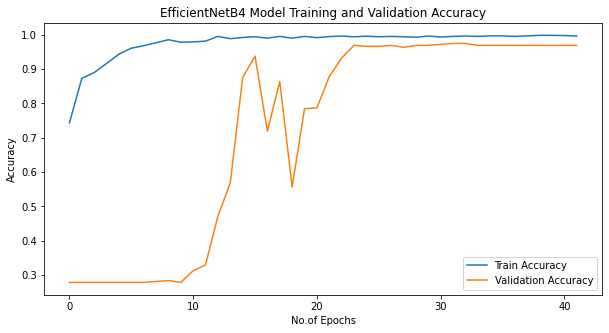

In [65]:
# plotting EfficientNet B4 Model Accuracy history
fig, ax = plt.subplots(figsize = (10,5))
hist_efficientnetb4 = history_efficientnetb4.history
plt.plot(range(len(hist_efficientnetb4["accuracy"])), hist_efficientnetb4["accuracy"], label = "Train Accuracy")
plt.plot(range(len(hist_efficientnetb4["val_accuracy"])), hist_efficientnetb4["val_accuracy"], label = "Validation Accuracy")
plt.title('EfficientNetB4 Model Training and Validation Accuracy')
plt.xlabel('No.of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

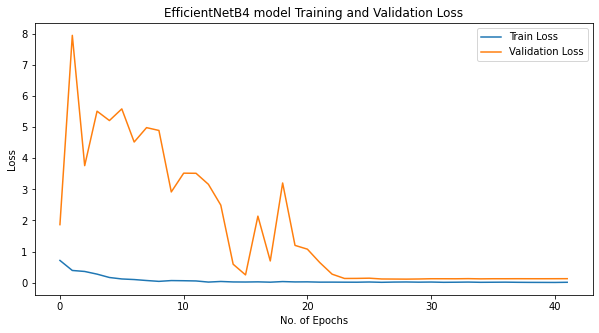

In [66]:
# plotting EfficientNet B4 Model Loss history
fig, ax = plt.subplots(figsize = (10,5))
hist_efficientnetb4 = history_efficientnetb4.history
plt.plot(range(len(hist_efficientnetb4["loss"])), hist_efficientnetb4["loss"], label = "Train Loss")
plt.plot(range(len(hist_efficientnetb4["val_loss"])), hist_efficientnetb4["val_loss"], label = "Validation Loss")
plt.title('EfficientNetB4 model Training and Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Comparing all Models

In [2]:
from prettytable import PrettyTable

myTable= PrettyTable(["Deep Learning Models", "Train Accuracy", "Validation Accuracy"])
# adding rows
myTable.add_row(["VGG-19", "0.7331", "0.6903"])
myTable.add_row(["ResNet50", "0.9703", "0.9574"])
myTable.add_row(["EfficientNet B4", "0.9949", "0.9744"])

print(myTable)

+----------------------+----------------+---------------------+
| Deep Learning Models | Train Accuracy | Validation Accuracy |
+----------------------+----------------+---------------------+
|        VGG-19        |     0.7331     |        0.6903       |
|       ResNet50       |     0.9703     |        0.9574       |
|   EfficientNet B4    |     0.9949     |        0.9744       |
+----------------------+----------------+---------------------+


We can observe that EfficientNet B4 gives best accuracy on our dataset.

# 7. Testing Best Model

As EfficientNet B4 gives best accuracy we will be using saved model weights for predicting test images. 

In [32]:
test.head()

,image_id,image_path
0,Test_0,images/Test_0.jpg
1,Test_1,images/Test_1.jpg
2,Test_2,images/Test_2.jpg
3,Test_3,images/Test_3.jpg
4,Test_4,images/Test_4.jpg


In [56]:
# predicting values for test dataset
model = keras.models.load_model("best_model_efficientnetb4.hdf5")
predict_val = model.predict(test_generator, verbose = 1)

1821/1821 [==============================] - 117s 62ms/step


In [58]:
# storing predicted value in dataframe
test['healthy'] = predict_val[:, 0]
test['multiple_diseases'] = predict_val[:, 1]
test['rust'] = predict_val[:, 2]
test['scab'] = predict_val[:, 3]
test = test.drop(['image_path'], axis = 1)
test.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000005,2.237672e-05,9.999728e-01,8.445001e-08
1,Test_1,0.000321,1.086057e-03,9.985462e-01,4.648288e-05
2,Test_2,0.000010,3.058075e-06,3.639039e-08,9.999870e-01
3,Test_3,0.999997,7.571733e-07,1.762534e-06,4.214039e-07
4,Test_4,0.000976,6.192355e-03,9.927351e-01,9.622294e-05


In [59]:
# saving test dataframe for kaggle submission
test.to_csv("submission_new.csv", index=False)

After Submitting "submission_new.csv" file on Kaggle, we got the test accuracy of 0.95670 .